In [113]:
#https://www.kaggle.com/mithrillion/identifying-clusters-of-related-questions

from google.oauth2 import service_account
import pandas_gbq

credentials = service_account.Credentials.from_service_account_file(
    '/Users/maxim.semenov/xxx.json',
)

query1 = """SELECT
  EXTRACT(YEAR FROM creation_date) AS Year,
  COUNT(*) AS Number_of_Questions,
  ROUND(100 * SUM(IF(answer_count > 0, 1, 0)) / COUNT(*), 1) AS Percent_Questions_with_Answers
FROM
  `bigquery-public-data.stackoverflow.posts_questions`
GROUP BY
  Year
HAVING
  Year > 2008 AND Year < 2019
ORDER BY
  Year;
        """


df = pandas_gbq.read_gbq(query1, project_id="xxxx", credentials=credentials)



In [114]:
print(df)

   Year  Number_of_Questions  Percent_Questions_with_Answers
0  2009               343139                            99.7
1  2010               693332                            99.1
2  2011              1198587                            97.2
3  2012              1642687                            94.6
4  2013              2056613                            91.6
5  2014              2160361                            88.5
6  2015              2214389                            86.4
7  2016              2219199                            84.6
8  2017              2137687                            82.7
9  2018              2168086                            71.0


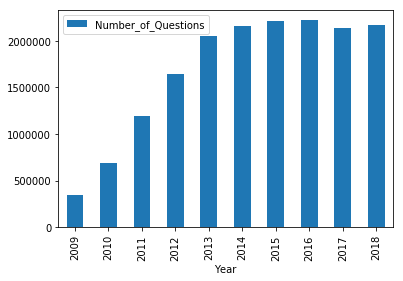

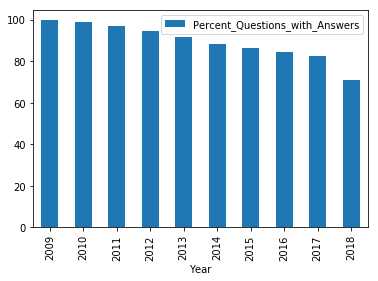

In [115]:
df.plot(kind='bar', x='Year', y='Number_of_Questions');
df.plot(kind='bar', x='Year', y='Percent_Questions_with_Answers');

In [116]:
query2 = """SELECT id, title, body, creation_date, owner_user_id, score 
FROM `bigquery-public-data.stackoverflow.posts_questions`
LIMIT 50000
        """

configurationsamle = {
    "query": {
     "allowLargeResults": "True",
     "destinationTable": {
        "projectId": "xxx",
        "tableId": "stackoverflowquestionssample2",
        "datasetId": "stackoverflow"
     }
  }
}

#configuration = {
#    "query": {
#     "allowLargeResults": "True",
#     "destinationTable": {
#        "projectId": "xxx",
#        "tableId": "stackoverflowquestions",
#        "datasetId": "stackoverflow"
#     }
# }
#}

#stackoverflowquestions table - Table size	25.26 GB Number of rows	17,278,709

df1 = pandas_gbq.read_gbq(query2, credentials=credentials, configuration=configurationsamle)


In [237]:
df1.head()
df1.dropna(inplace=True)
df1.drop_duplicates(subset ="id", 
                     keep = False, inplace = True)

In [382]:


#df1 = df1.drop(['creation_date'], axis=1)

df1 = df1.sort_values(by=['id'])
df1 = df1.reset_index(drop=True)


In [383]:
df1.head()

,id,title,body,owner_user_id,score
0,2262,ASP.NET URL Rewriting,<p>How do I rewrite URL's in ASP.NET?</p>\n\n<...,383.0,31
1,3315,Can I have a method returning IEnumerator<T> a...,<p>I need to set the height of every textbox o...,503.0,17
2,6155,Common Types of Subversion Hooks,<p>What kinds of hook scripts are people using...,204.0,39
3,6765,Java + SQL Server - a viable solution?,<p>I'm going to start a new project - rewritin...,837.0,10
4,17533,Request Windows Vista UAC elevation if path is...,"<p>For my C# app, I don't want to always promp...",1147.0,26


In [499]:
#dat = pd.read_csv("Questions.csv", encoding='latin1')
#dat['Title'].fillna("None", inplace=True)
#dat['Score'].fillna(0, inplace=True)
#dat.head()

In [500]:
#df1.sort_values(by=['id'])

# select a sample - results will improve without sampling in tf-idf caluculations, but due to
# Kaggle kernel memory limit we have to make a compromise here.
selected_ids = np.random.choice(range(df1.shape[0]), 10000, replace=False)
sample = df1.loc[selected_ids, :]
sample.shape

#selected_ids2 = np.random.choice(range(dat.shape[0]), 10000, replace=False)
#sample1 = dat.loc[selected_ids2, :]
#sample1.shape

(10000, 5)

In [501]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
from multiprocessing import Pool
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import re
from itertools import chain
from collections import Counter
import pickle
import scipy.io as scio
from sklearn.decomposition import TruncatedSVD
import scipy.spatial.distance as distance
import scipy.cluster.hierarchy as hierarchy
from scipy.stats import pearsonr

In [502]:
sample.head()

,id,title,body,owner_user_id,score
8394,10958640,What is out of box features in sharepoint,<p>What is out of box features in sharepoint. ...,1220350.0,-1
48887,54690741,How to Post PR comment from jenkinsfile,<p>I am running Multibranch pipeline jobs usin...,10711564.0,0
27134,32030302,curl php - CURLOPT_PROXY,<pre><code> $options = array( \n CURLOPT_R...,5231278.0,0
42159,48159195,"Android, OpenCv: crop fails when crop occurs w...",<p>I have a class which receives frames taken ...,7644020.0,0
48419,54296542,R: Remove (rm) a variable where that variable'...,"<p>In R, I would like to be able to <em>remove...",4603287.0,0


In [503]:
#Cleaning the data
def clean_text(text):
    global EMPTY
    EMPTY = ''
    
    if not isinstance(text, str): 
        return text
    
    # extract all the code part 
    text = re.sub('<pre><code>.*?</code></pre>', EMPTY, text)

    def replace_link(match):
        return EMPTY if re.match('[a-z]+://', match.group(1)) else match.group(1)
    
    text = re.sub('<a[^>]+>(.*)</a>', replace_link, text)
    
    # remove the html tags finally
    return re.sub('<[^>]+>', EMPTY, text)

In [504]:
corpus = sample['body'].apply(clean_text).str.lower()

In [506]:
def combine_title_body(tnb):
    return tnb[0] + " " + tnb[1]

In [505]:
len(corpus)

10000

In [507]:
p = Pool(8)
combined_corpus = p.map(combine_title_body, zip(df1['title'], corpus))
p.close()

In [508]:
len(combined_corpus)

10000

In [509]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/maxim.semenov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/maxim.semenov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/maxim.semenov/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [510]:
lem = WordNetLemmatizer()
def cond_tokenize(t):
    if t is None:
        return []
    else:
        return [lem.lemmatize(w.lower()) for w in word_tokenize(t)]

p = Pool(8)
tokens = list(p.imap(cond_tokenize, combined_corpus))
p.close()

len(tokens)

10000

In [511]:
# stops = stopwords.words('english')
pure_tokens = [" ".join(sent) for sent in tokens]

In [512]:
vectorizer = TfidfVectorizer(min_df=1, max_features=2000, stop_words='english', ngram_range=[1, 1], sublinear_tf=True)
tfidf = vectorizer.fit_transform(pure_tokens)

In [513]:
idfs = pd.DataFrame([[v, k] for k, v in vectorizer.vocabulary_.items()], columns=['id', 'word']).sort_values('id')
idfs['idf'] = vectorizer.idf_
idfs.sort_values('idf').head(10)

,id,word,idf
19,1877,using,1.978000
58,856,gt,1.997601
6,414,code,2.027602
116,1108,lt,2.103323
34,1063,like,2.185578
206,1925,want,2.303157
10,1216,new,2.362678
14,1869,use,2.375652
300,755,file,2.387195
154,687,error,2.409458


In [514]:
#Compress using SVD
tsvd = TruncatedSVD(n_components=500)
transformed = tsvd.fit_transform(tfidf)
np.sum(tsvd.explained_variance_ratio_)

0.6046569308871916

In [515]:
transformed.shape

(10000, 500)

In [516]:
# calculate pairwise cosine distance
D = distance.pdist(transformed, 'cosine')

In [517]:
# hierarchical clustering - tree calculation
L = hierarchy.linkage(D)

In [518]:
# mean distance between clusters
np.mean(D)

0.93597969625959

In [519]:
# split clusters by criterion. Here 0.71 is used as the inconsistency criterion. Adjust the
# number to change cluster sizes
cls = hierarchy.fcluster(L, 0.8, criterion='inconsistent')

In [520]:
df_cls = pd.DataFrame({'Pos': sample['id'], 'Cluster': cls})
cnts = df_cls.groupby('Cluster').size().sort_values(ascending=False)
cnts.sort_values(ascending=False).head()

Cluster
1600    33
430     19
1281    18
1393    18
719     17
dtype: int64

In [521]:
df_cls.head()

,Pos,Cluster
8394,10958640,269
48887,54690741,609
27134,32030302,630
42159,48159195,1042
48419,54296542,5942


In [522]:
sample.head()

,id,title,body,owner_user_id,score
8394,10958640,What is out of box features in sharepoint,<p>What is out of box features in sharepoint. ...,1220350.0,-1
48887,54690741,How to Post PR comment from jenkinsfile,<p>I am running Multibranch pipeline jobs usin...,10711564.0,0
27134,32030302,curl php - CURLOPT_PROXY,<pre><code> $options = array( \n CURLOPT_R...,5231278.0,0
42159,48159195,"Android, OpenCv: crop fails when crop occurs w...",<p>I have a class which receives frames taken ...,7644020.0,0
48419,54296542,R: Remove (rm) a variable where that variable'...,"<p>In R, I would like to be able to <em>remove...",4603287.0,0


In [523]:
# add clusters to question data
bc = pd.concat([sample, df_cls], axis=1)
bc.head()

,id,title,body,owner_user_id,score,Pos,Cluster
8394,10958640,What is out of box features in sharepoint,<p>What is out of box features in sharepoint. ...,1220350.0,-1,10958640,269
48887,54690741,How to Post PR comment from jenkinsfile,<p>I am running Multibranch pipeline jobs usin...,10711564.0,0,54690741,609
27134,32030302,curl php - CURLOPT_PROXY,<pre><code> $options = array( \n CURLOPT_R...,5231278.0,0,32030302,630
42159,48159195,"Android, OpenCv: crop fails when crop occurs w...",<p>I have a class which receives frames taken ...,7644020.0,0,48159195,1042
48419,54296542,R: Remove (rm) a variable where that variable'...,"<p>In R, I would like to be able to <em>remove...",4603287.0,0,54296542,5942


In [524]:
# calculate cluster stats
stats = bc.groupby('Cluster')['score'].describe()

In [525]:
stats.sort_values(by='count', ascending=False).head()

,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
1600,33.0,0.545455,0.971175,0.0,0.0,0.0,1.0,3.0
430,19.0,0.736842,0.991189,-1.0,0.0,0.0,2.0,2.0
1393,18.0,1.611111,3.912858,-1.0,0.0,0.0,1.0,14.0
1281,18.0,1.222222,1.733937,-2.0,0.0,1.0,2.0,5.0
719,17.0,1.294118,2.867157,-2.0,0.0,1.0,1.0,11.0


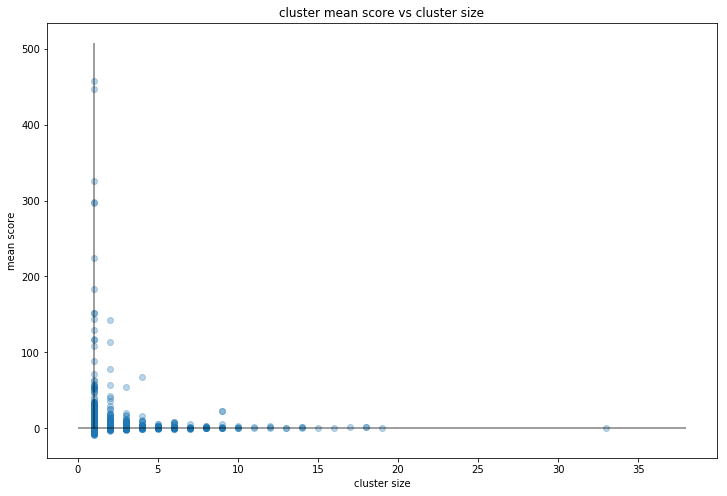

In [527]:
plt.figure(figsize=(12, 8))
plt.hlines([0], xmin=0, xmax=np.max(stats['count']) + 5, alpha=0.5)
plt.vlines([1], ymin=0, ymax=np.max(stats['mean']) + 50, alpha=0.5)
plt.scatter(stats['count'], stats['mean'], alpha=0.3)
plt.title("cluster mean score vs cluster size")
plt.xlabel("cluster size")
plt.ylabel("mean score")
plt.show()

In [528]:
bc.loc[bc['Cluster'] == cnts.index[0]][['score', 'title', 'body']]

,score,title,body
42162,0,Wordpress site not loading css correctly in Ch...,<p>I'm working on a test website in wordpress ...
589,2,The weirdest css issue I have ever seen,"<p>Below I have 2 css codes for a div, please ..."
48102,0,i am setting a Menu Bar with drop-down but the...,<p>i am setting a Menu Bar with drop-down but ...
26505,3,CSS - Why is my content not scrolling?,"<p><strong>UPDATE 2</strong> I just fixed ""Edi..."
29067,0,Wordpress CSS Media-query causes sub menu to a...,<p>I'm new to CSS so am trying my best to solv...
6610,0,How to detect that the last or 1st list item i...,<p>I'm doing a carousel for the 1st time and I...
7652,1,Div page design looks wrong in other resolutions,<p>I have a main div of 75% width and 100% hei...
34575,0,"Need Explanation for Display, Before, After At...","<p><div class=""snippet"" data-lang=""js"" data-hi..."
40426,0,unidentified space between header and body,<p>I have been browsing about it but i cannot ...
39018,0,My page is getting cut off in the safari browser,<p>I need some help with a webpage I am design...


In [529]:
bc.loc[bc['Cluster'] == cnts.index[1]][['score', 'title', 'body']]

,score,title,body
8374,2,Interupts Vs Poling a Device,"<p>In my application a no. of devices (camera,..."
4768,2,Is it possible to browse the bundle/package fi...,<p>Some background: I have a data file in the ...
6598,0,WebService on embedded device that can be acce...,<p>I have an embedded device that runs WinCE w...
38582,2,Turning off Microsoft Surface Dial Sleep Mode,<p>while developing for the new Microsoft Surf...
49201,0,How to display the pandas data frame that is s...,<p>I have a data frame to which I have applied...
654,2,Custom DirectShow graph source filter,<p>All I need to do is play an AVI video from ...
44598,0,Limit resident memory using cgroups,<p>I have an application that maps some large ...
27466,2,Allocate physical memory buffer for ARM64 Linu...,<p>I have to implement an ARM64 Linux driver f...
8442,2,MPI and OpenMP on Desktop CPUs,<p>I was just wondering how is it possible tha...
23742,1,"Difference of Unary operators ( += , =+ , ++x ...",<p>What is the difference between these unary ...


In [530]:
bc.loc[bc['Cluster'] == cnts.index[2]][['score', 'title', 'body']]
#We can improve our clusters by increasing sample size, using entire dataset to calculate tf-idf, 
#adjusting cluster splitting criterion, using non-exclusive clustering techniques etc.

,score,title,body
47431,5,Watershed Segmentation excluding alone object?,"<h2>Problem</h2>\n\n<p>Using <a href=""https://..."
28346,1,scipy.quad trouble for decreasing functions ov...,<p>I have a problem with <code>scipy.quad</cod...
48912,0,matplotlib: controlling position of y axis lab...,<p>I wrote a Python script based on matplotlib...
41645,1,How can I use word2vec to train a classifier?,<p>The code is used to generate word2vec and u...
10282,2,Plot really big file in python (5GB) with x ax...,<p>I am trying to plot a very big file (~5 GB)...
39491,-2,Looping through subplot which returns function...,<p>I am trying to loop subplot for n rows 2 co...
42010,0,'wordcloud' is not defined python3.6,<p>I am trying to make a wordcloud on movie ge...
32441,2,Dynamically update title and text in matplotli...,<p>I'd like to make an animation with matplotl...
42468,4,reconstructing signal with tensorflow.contrib....,<p><strong><em>UPDATE</strong>: I've reimpleme...
48151,0,Catboost Regression. Function Extrapolation,<p>I'm new at ML and have a problem with catbo...
